In [1]:
from typing import Sequence

import torch
import numpy as np
from models import MLPModel, FancyMLPModel
from agents import Agent
from collectors import Memory, CrowdCollector
from environments import UnityCrowdEnv, UnitySimpleCrowdEnv
from policy_optimization import CrowdPPOptimizer
from trainers import PPOCrowdTrainer

from tqdm import tqdm, trange
from mlagents_envs.environment import UnityEnvironment

from utils import transpose_batch, concat_batches, concat_crowd_batch, tanh_norm, atanh_unnorm

from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

import seaborn as sns
import matplotlib.pyplot as plt

from utils import discount_rewards_to_go, get_episode_lens

In [2]:
# channel = EngineConfigurationChannel()


# env = UnityCrowdEnv(file_name="Test.app", side_channels=[channel], no_graphics=False)
# env = UnityCrowdEnv(file_name=None)
env = UnitySimpleCrowdEnv(file_name=None)



# channel.set_configuration_parameters(time_scale=1, width=1000, height=1000, quality_level=0)#, target_frame_rate=600)

This means that some features may not work unless you upgrade the package with the lower version.Please find the versions that work best together from our release page.
https://github.com/Unity-Technologies/ml-agents/releases


In [3]:
env.engine_channel.set_configuration_parameters(time_scale=100, width=1000, height=1000, quality_level=0)#, target_frame_rate=600)

In [4]:
model = MLPModel({
    "input_size": 90,
})

# agent = Agent(model)

agent = Agent(model, action_range=(
    torch.tensor([-.3, -1.]),
    torch.tensor([ 1.,  1.])
))

In [5]:
trainer_config = {
    # "steps": 10000,  # number of steps we want in one PPO step
    "episodes": 1,  # number of episodes to collect

    # Tensorboard settings
    "tensorboard_name": "fixed_speed",  # str, set explicitly

    # PPO
    "ppo_config": {
        # GD settings
        "optimizer": "adam",
        "optimizer_kwargs": {
            "lr": 1e-4,
            "betas": (0.9, 0.999),
            "eps": 1e-7,
            "weight_decay": 0,
            "amsgrad": False
        },
        "gamma": 0.95,  # Discount factor

        # PPO settings
        "ppo_steps": 10,  # How many max. gradient updates in one iterations
        "eps": 0.1,  # PPO clip parameter
        "target_kl": 0.01,  # KL divergence limit
        "value_loss_coeff": 0.1,
        "entropy_coeff": 0.1,
        "max_grad_norm": 0.5,

        # Backpropagation settings
        "use_gpu": False,
    }
}

trainer = PPOCrowdTrainer(agent, env, trainer_config)


In [6]:
trainer.train(1000)

  1%|▏         | 13/1000 [02:36<3:17:35, 12.01s/it]


Begin training, logged in /Users/redtachyon/tb_logs/fixed_speed_2020-11-18_18-46-30


KeyboardInterrupt: 

In [7]:
env.engine_channel.set_configuration_parameters(time_scale=1, width=1000, height=1000, quality_level=0)#, target_frame_rate=600)

# import time
# time.sleep(2)

env.reset()
batch = trainer.collector.collect_data(num_episodes=1, disable_tqdm=False)

100%|██████████| 500/500 [00:37<00:00, 13.41it/s]


In [9]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

In [ ]:
data = trainer.collector.collect_data(num_episodes=1)

In [20]:
batch = concat_crowd_batch(data)

In [25]:
logprobs, values, entropies = agent.evaluate_actions(batch)

In [29]:
values.shape

torch.Size([2000])

In [8]:
import time
time.sleep(2)

env.reset()
batch = trainer.collector.collect_data(num_episodes=2, disable_tqdm=False)

 43%|████▎     | 433/1000 [00:19<00:26, 21.69it/s]


UnityCommunicatorStoppedException: Communicator has exited.

In [14]:
env.close()

In [78]:
ppo = CrowdPPOptimizer(agent, {"ppo_steps": 5})

In [79]:
agent.model.hidden_layers[1].weight

Parameter containing:
tensor([[-0.0096, -0.0064, -0.2065,  ..., -0.2276, -0.0514,  0.2679],
        [ 0.2730, -0.2026, -0.2138,  ...,  0.1657,  0.0743,  0.0466],
        [-0.2094,  0.2142,  0.0722,  ..., -0.1446,  0.1019, -0.2680],
        ...,
        [-0.0843, -0.0358, -0.1844,  ..., -0.0895, -0.0691, -0.1422],
        [ 0.1649, -0.1459, -0.2758,  ...,  0.1108,  0.1207,  0.0413],
        [-0.0731, -0.1504,  0.0497,  ..., -0.3060, -0.1942,  0.1115]],
       requires_grad=True)

In [84]:
ppo.train_on_data(batch, step=0)

{'crowd/time_update': 0.05107688903808594,
 'crowd/kl_divergence': 0.003407703945413232,
 'crowd/ppo_steps_made': 5,
 'crowd/policy_loss': -0.0008314575534313917,
 'crowd/value_loss': 1.4837126731872559,
 'crowd/total_loss': 0.29555290937423706,
 'crowd/total_steps': 9000.0,
 'crowd/episode_len_mean': 500.0,
 'crowd/episode_len_median': 500.0,
 'crowd/episode_len_min': 500,
 'crowd/episode_len_max': 500,
 'crowd/episode_len_std': 0.0,
 'crowd/episode_reward_mean': -22.172388076782227,
 'crowd/episode_reward_median': -19.99441909790039,
 'crowd/episode_reward_min': -46.39445877075195,
 'crowd/episode_reward_max': -4.994082450866699,
 'crowd/episode_reward_std': 12.951112747192383,
 'crowd/episodes_this_iter': 18,
 'crowd/mean_entropy': -1.480130910873413}

In [75]:
agent.model.hidden_layers[1].weight

Parameter containing:
tensor([[-0.0096, -0.0064, -0.2065,  ..., -0.2276, -0.0514,  0.2679],
        [ 0.2730, -0.2026, -0.2138,  ...,  0.1657,  0.0743,  0.0466],
        [-0.2094,  0.2142,  0.0722,  ..., -0.1446,  0.1019, -0.2680],
        ...,
        [-0.0843, -0.0358, -0.1844,  ..., -0.0895, -0.0691, -0.1422],
        [ 0.1649, -0.1459, -0.2758,  ...,  0.1108,  0.1207,  0.0413],
        [-0.0731, -0.1504,  0.0497,  ..., -0.3060, -0.1942,  0.1115]],
       requires_grad=True)

In [8]:
t_batch = transpose_batch(batch)

all_data = concat_crowd_batch(t_batch)

In [9]:
all_data['actions'].numpy().ravel()

array([0.30398947, 0.42324162, 0.43882394, ..., 0.33990902, 0.30477524,
       0.28048235], dtype=float32)

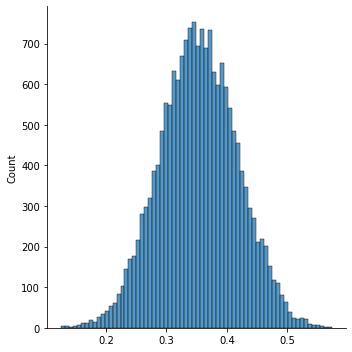

In [10]:
sns.displot(all_data['actions'].numpy().ravel())

In [12]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

In [75]:
obs_dict = env.reset()
for _ in trange(100):
    action_dict = {key: np.array([1., np.random.rand() - 0.5]) for key in obs_dict}
    env.step(action_dict)

100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


In [31]:
env.close()

In [22]:
env.unity.get_steps("Person2?team=0")[1]

In [100]:
env.unity.step()

In [20]:
env.close()

In [22]:
obs_dict["Person2?team=0&id=10"]

KeyError: 'Person2?team=0&id=10'

In [22]:
env.unity.get_steps("Person1?team=0")[0].obs[0].shape

(9, 84)

In [19]:
dec, ter = env.unity.get_steps("Person2?team=0")

In [20]:
dec.obs[0].shape

(0, 84)

In [21]:
ter.obs[0]

array([], shape=(0, 84), dtype=float32)

In [26]:
env.close()

In [15]:
for _ in trange(1000):
    action_dict = {key: np.array([1., np.random.rand() - 0.5]) for key in obs_dict if key.startswith("Person")}
    env.step(action_dict)

100%|██████████| 1000/1000 [00:05<00:00, 196.88it/s]


In [16]:
for _ in trange(100):
    action_dict = {key: np.array([0., 0.]) for key in obs_dict if key.startswith("Person")}
    env.step(action_dict)

100%|██████████| 100/100 [00:00<00:00, 185.66it/s]


In [14]:
env._get_step_info(False)[0]["Person1?team=0&id=1"]

array([ 0.        ,  1.        ,  0.        ,  0.11249997,  0.        ,
        1.        ,  0.        ,  0.11704366,  0.        ,  1.        ,
        0.        ,  0.11704365,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.18531974,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.17493977,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.18531969,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.30322984,  0.        ,  0.  

In [15]:
env.close()

In [14]:
for _ in trange(50):
    env.unity.set_actions("Person1?team=0", np.repeat([[1, -1]], 9, 0))

    env.unity.step()
    

for _ in trange(50):
    env.unity.set_actions("Person1?team=0", np.repeat([[1, 1]], 9, 0))

    env.unity.step()


100%|██████████| 50/50 [00:00<00:00, 107.58it/s]


In [6]:
env.close()

In [5]:
obs_dict, done_dict = env._get_step_info()

In [8]:
obs_dict["Person1?team=0&id=0"]

array([ 0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.  

In [15]:
env.close()

In [26]:
foo = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(foo)
print()
print(np.take(foo, [2, 1, 0], axis=0))

[[1 2 3]
 [4 5 6]
 [7 8 9]]

[[7 8 9]
 [4 5 6]
 [1 2 3]]


In [6]:
dict(env.behavior_specs)

{'Person1?team=0': BehaviorSpec(observation_shapes=[(84,), (6,)], action_type=<ActionType.CONTINUOUS: 1>, action_shape=2),
 'Person2?team=0': BehaviorSpec(observation_shapes=[(84,), (6,)], action_type=<ActionType.CONTINUOUS: 1>, action_shape=2)}

In [31]:
env.unity.behavior_specs["Person1?team=0"].action_shape

2

In [40]:
dec, ter = env.unity.get_steps("Person1?team=0")

In [42]:
dec.reward

array([0.35005403, 0.33820367, 0.33820558, 0.35005403, 0.35005593,
       0.35005403, 0.35005593, 0.35005593, 0.33820558], dtype=float32)

In [44]:
dec.agent_id

array([ 0,  1,  2,  5,  6,  7, 13, 16, 17], dtype=int32)

In [34]:
{1: 2, 3: 4}.get(4, 10)

10

In [37]:
foo = [
    np.array([1, 2, 3]),
    np.array([[2,3,4]]),
    np.array([3,4,5])
]

In [38]:
np.array(foo)

<ipython-input-38-3d5441f5c0e8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(foo)


array([array([1, 2, 3]), array([[2, 3, 4]]), array([3, 4, 5])],
      dtype=object)

In [10]:
for _ in trange(20):
    env.set_actions("Person?team=0", np.repeat([[1, -1]], 18, 0))

    env.step()

100%|██████████| 20/20 [00:01<00:00, 11.83it/s]


In [8]:
ter.agent_id

array([], dtype=int32)

In [9]:
foo = dict()

In [11]:
foo.setdefault('k', []).append(3)

In [12]:
foo

{'k': [3]}

In [ ]:
def get_obs(env: UnityEnvironment):
    names = env.behavior_specs.keys()
    res = {}
    for name in names:
        decisions, terminals = env.get_steps(name)
        for i in decisions.agent_id:
            agent_name = f"{name}&id={i}"
            obs = decisions.obs
            


def get_step_data(env: UnityEnvironment, names: Sequence[str]):
    pass

In [26]:
env.reset()

In [16]:
env.step()

In [18]:
o1, o2 = env.get_steps("Person?team=0")[0].obs

In [20]:
o1.shape

(8, 84)

In [22]:
o2.shape

(8, 3)

In [30]:
np.concatenate((o1, o2), axis=1).shape

(8, 87)

In [ ]:
def get_obs(env: UnityEnvironment, names: Sequence[str]):
    res = {}
    for name in names:
        decisions, terminals = env.get_steps(name)
        res[name] = np.concatenate(env.g)

In [15]:
env.step()

In [16]:
env.close()

In [2]:
model = MLPModel({})

In [3]:
inp = torch.randn(100, 21)

In [4]:
action, _, extra = model(inp)

In [5]:
agent = Agent(model)

In [10]:
torch.stack(torch.tensor([1, 3, 3, 2]))

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [11]:
import numpy as np

In [12]:
foo = [np.array([1, 2, 3]) for _ in range(10)]